# Pre requisites

In [59]:
import cv2

In [5]:
# Import standard dependencies
import os
import random
import numpy as np

from matplotlib import pyplot as plt

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

### tf.data.Dataset

The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

The simplest way to create a dataset is to create it from a python `list`

In [38]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [39]:
# Represents a potentially large set of elements.

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [40]:
# Now we have a DATA PIPELINE 
# A way to iterate over all the data points in a dir

dir_test = anchor.as_numpy_iterator()

print(dir_test.next())

b'data\\anchor\\334093f9-209f-11ef-94fe-f21805e91111.jpg'


## 3.2 Preprocessing - Scale and Resize

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100 x 100 x 3 <--- size of 100 x 100 and ALL 3 channel
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

- def pre_process()
- dataset.map( pre_process )
> applies pre_process fn to each data_label of dataset


- [ ] tf.io.decode_jpeg() docmentation is interesting ; there is a way to downscale WHILE DECODING , but only  by 2,4,8 ; Try Downscaling by 255 



In [41]:
tf.io.decode_jpeg??

Signature:
tf.io.decode_jpeg(
    contents: Annotated[Any, <class 'tensorflow.security.fuzzing.py.annotation_types.String'>],
    channels: int = 0,
    ratio: int = 1,
    fancy_upscaling: bool = True,
    try_recover_truncated: bool = False,
    acceptable_fraction: float = 1,
    dct_method: str = '',
    name=None,
) -> Annotated[Any, <class 'tensorflow.security.fuzzing.py.annotation_types.UInt8'>]
Source:   
def decode_jpeg(contents: Annotated[Any, _atypes.String], channels:int=0, ratio:int=1, fancy_upscaling:bool=True, try_recover_truncated:bool=False, acceptable_fraction:float=1, dct_method:str="", name=None) -> Annotated[Any, _atypes.UInt8]:
  r"""Decode a JPEG-encoded image to a uint8 tensor.

  The attr `channels` indicates the desired number of color channels for the
  decoded image.
  
  Accepted values are:
  
  *   0: Use the number of channels in the JPEG-encoded image.
  *   1: output a grayscale image.
  *   3: output an RGB image.
  
  If needed, the JPEG-encoded imag

In [42]:
byte_img = tf.io.read_file('data\\anchor\\334093f9-209f-11ef-94fe-f21805e91111.jpg')
img_decoded = tf.io.decode_jpeg(byte_img)
img_resized = tf.image.resize(img_decoded, (100,100) )
img_scaled_down = img_resized / 255.0

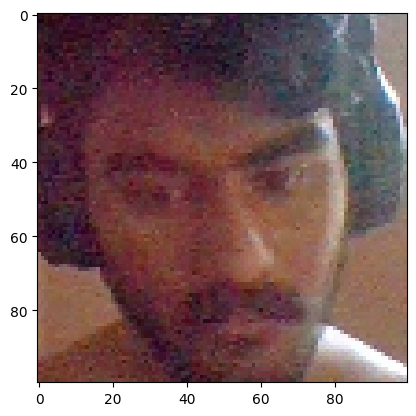

In [51]:
# plt.imshow(img_resized) does not work as the img_resized in a tensor ( not a numpy library )
# plt.imshow(img_resized.numpy()) 
plt.imshow(img_resized.numpy().astype(np.uint8) ) 

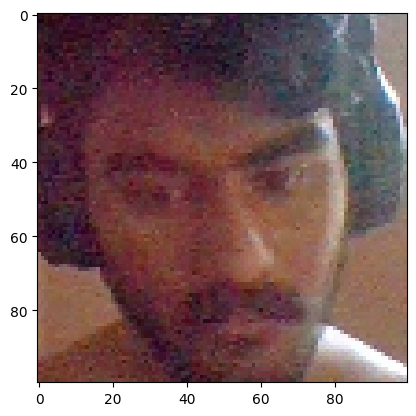

In [45]:
plt.imshow(img_scaled_down)

### Are these two the same image (or) Comparing Images

Finding if two images are equal with `Opencv`, is a quite simple operation.

There are 2 fundamental elements to consider:

1. The images have both the `same size` and `channels`
2. Each `pixel` has the `same value`

- If they have the `same sizes and channels`, then `SUBTRACT`. 
- The operation cv2.subtract(image1, image2) simply subtract from each pixel of the first image, the value of the corresponding pixel in the second image.
- A `colored image` has `3 channels (blue, green, and red)`
- The `cv2.subtract()` operation makes the subtraction `for every single channel` and we need to check if all the three channels are black.

In [56]:
im_resz_shape = img_resized.numpy().shape
im_scale_shape = img_scaled_down.numpy().shape
print(f'Same size and channels = { im_scale_shape == im_resz_shape} ; scaled_down = { im_scale_shape } ; resize = {im_resz_shape}')

Same size and channels = True ; scaled_down = (100, 100, 3) ; resize = (100, 100, 3)


In [61]:
difference = cv2.subtract(img_resized.numpy() , img_scaled_down.numpy())
b, g, r = cv2.split(difference)
if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
    print("The images are completely Equal")
else:
    print("The images are different")

The images are different


<font size="5"> => So they are indeed Different ; Learnt something about processing images in cv2 </font>

In [67]:
# What exactly is the difference ?

# print(b, g, r)
# plt.imshow(difference.astype(np.uint8)  ) # <----- this is insane

## 3.3 Create Labelled Dataset

## 3.4 Build Train and Test Partition

# 4. Model Engineering

## 4.1 Build Embedding Layer

## 4.2 Build Distance Layer

## 4.3 Make Siamese Model

# 5. Training

## 5.1 Setup Loss and Optimizer

## 5.2 Establish Checkpoints

## 5.3 Build Train Step Function

## 5.4 Build Training Loop

## 5.5 Train the model

# 6. Evaluate Model

# 7. Save Model

# 8. Real Time Test